In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from xgboost import XGBClassifier, plot_importance

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
df_clients = pd.read_excel("df_income_transformed.xlsx", sheet_name="ProcessedData")
df_products = pd.read_excel("Dataset2_Needs.xls", sheet_name="Products")

X = df_clients[['Age', 'Income', 'Wealth', 'Wealth / Income', 'RiskPropensity * Wealth', 'Income / FamilyMembers', 'RiskPropensity * Income']]
y = df_clients[ 'IncomeInvestment']

In [3]:
# 1. Définir la cible
target1 = 'IncomeInvestment'

y = df_clients[[target1]]  # double [[]] pour DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modèle
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# 4. Prédictions
y_pred_test = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X)[:, 1]  # probabilité sur l'ensemble

# 5. Rapport de classification
print(f"\n📊 Résultats pour : {target1}")
print("-" * 40)
print(classification_report(y_test, y_pred_test))

# 6. Stockage des probabilités dans df_clients
df_clients[f'reg_log_{target1}_proba'] = y_pred_proba



📊 Résultats pour : IncomeInvestment
----------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       619
           1       0.78      0.59      0.67       381

    accuracy                           0.78      1000
   macro avg       0.78      0.74      0.75      1000
weighted avg       0.78      0.78      0.77      1000



C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [18:55:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training XGBoost for: IncomeInvestment

Classification Report :
               precision    recall  f1-score   support

           0       0.79      0.94      0.86       619
           1       0.86      0.59      0.70       381

    accuracy                           0.81      1000
   macro avg       0.82      0.76      0.78      1000
weighted avg       0.81      0.81      0.80      1000

ROC AUC Score : 0.7956


<Figure size 1000x600 with 0 Axes>

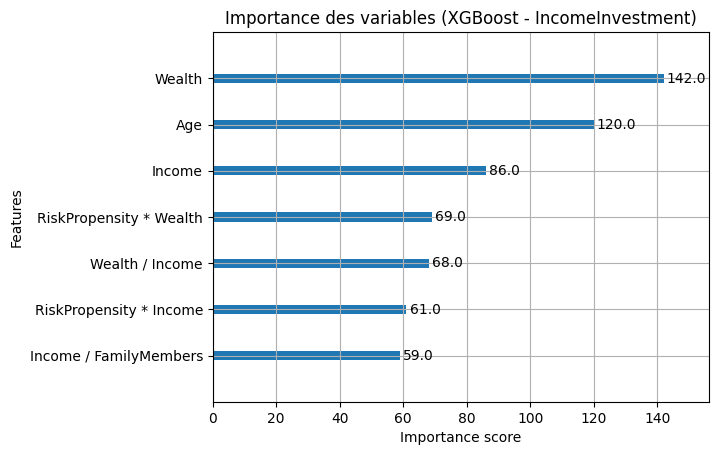

In [4]:
targets = ['IncomeInvestment']

for target in targets:
    print(f"\nTraining XGBoost for: {target}")
    print("=" * 50)

    
    model = XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    
    model.fit(X_train, y_train[target])

    # Prédictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Évaluation
    print("\nClassification Report :\n", classification_report(y_test[target], y_pred))
    print(f"ROC AUC Score : {roc_auc_score(y_test[target], y_proba):.4f}")

    # Affichage des features
    plt.figure(figsize=(10, 6))
    plot_importance(model)
    plt.title(f"Importance des variables (XGBoost - {target})")
    plt.show()




GridSearch XGBoost pour : IncomeInvestment
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Meilleurs paramètres : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}

📊 Classification Report :
               precision    recall  f1-score   support

           0       0.78      0.90      0.84       619
           1       0.79      0.60      0.68       381

    accuracy                           0.79      1000
   macro avg       0.79      0.75      0.76      1000
weighted avg       0.79      0.79      0.78      1000

🎯 ROC AUC Score : 0.7747


C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [18:55:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 1000x600 with 0 Axes>

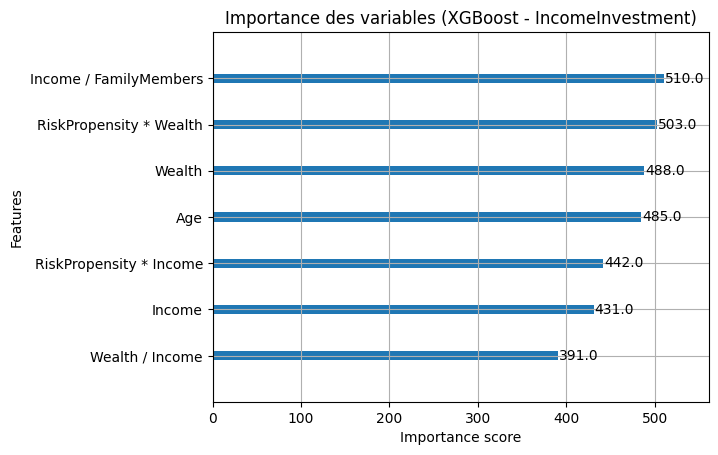

In [5]:
# Paramètres à tuner
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

for target in targets:
    print(f"\nGridSearch XGBoost pour : {target}")
    print("=" * 50)

    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)

    # Modèle de base
    xgb_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    # GridSearch
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='recall',  # ou 'roc_auc', 'accuracy', etc.
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("✅ Meilleurs paramètres :", grid_search.best_params_)

    # Meilleur modèle
    best_model = grid_search.best_estimator_

    # Évaluation
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    print("\n📊 Classification Report :\n", classification_report(y_test, y_pred))
    print(f"🎯 ROC AUC Score : {roc_auc_score(y_test, y_proba):.4f}")

    # Importance des variables
    plt.figure(figsize=(10, 6))
    plot_importance(best_model)
    plt.title(f"Importance des variables (XGBoost - {target})")
    plt.show()

    # Prédictions sur tout le dataset
    df_clients[f'xgb_proba_{target}'] = best_model.predict_proba(X)[:, 1]



Training Random Forest for: IncomeInvestment

Classification Report :
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       619
           1       0.80      0.58      0.67       381

    accuracy                           0.79      1000
   macro avg       0.79      0.75      0.76      1000
weighted avg       0.79      0.79      0.78      1000

ROC AUC : 0.7844


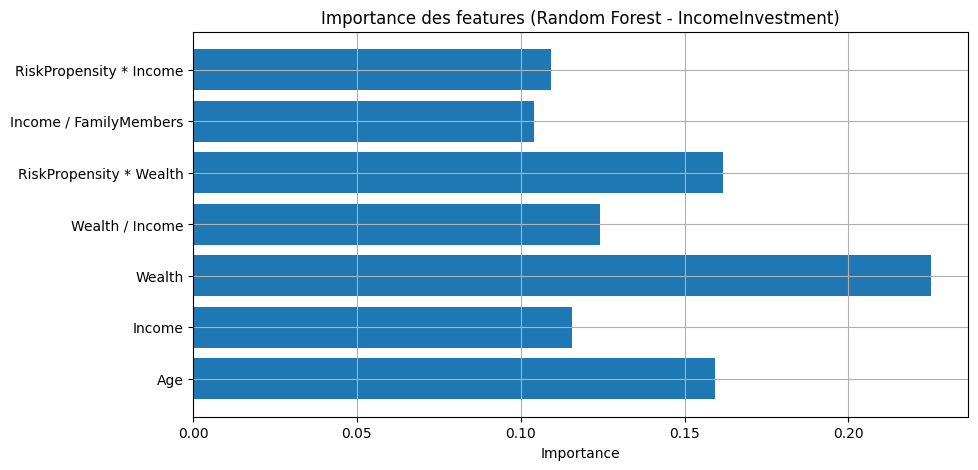

In [6]:
for target in targets:
    print(f"\nTraining Random Forest for: {target}")
    print("=" * 50)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)

    # Modèle de base
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    # Évaluation
    y_pred_rf = rf_model.predict(X_test)
    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

    print("\nClassification Report :")
    print(classification_report(y_test, y_pred_rf))
    print(f"ROC AUC : {roc_auc_score(y_test, y_proba_rf):.4f}")

    # Importance des variables
    importances = rf_model.feature_importances_
    feat_names = X.columns

    plt.figure(figsize=(10, 5))
    plt.barh(feat_names, importances)
    plt.title(f"Importance des features (Random Forest - {target})")
    plt.xlabel("Importance")
    plt.grid(True)
    plt.show()

    

In [7]:
# Grille des hyperparamètres
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

for target in targets:
    print(f"\n🔍 GridSearchCV Random Forest for: {target}")
    print("=" * 50)

    # Split (à nouveau pour la bonne target)
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)

    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

    grid_search_rf = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid_rf,
        scoring='roc_auc',
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid_search_rf.fit(X_train, y_train)
    print("🌟 Meilleurs paramètres :", grid_search_rf.best_params_)

    best_rf = grid_search_rf.best_estimator_

    # Évaluation
    y_pred_rf = best_rf.predict(X_test)
    y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

    
    print("\nClassification Report :")
    print(classification_report(y_test, y_pred_rf))
    print(f"ROC AUC : {roc_auc_score(y_test, y_proba_rf):.4f}")

    # Ajout des prédictions optimisées au DataFrame
    df_clients[f'rf_proba_{target}'] = best_rf.predict_proba(X)[:, 1]



🔍 GridSearchCV Random Forest for: IncomeInvestment
Fitting 3 folds for each of 48 candidates, totalling 144 fits
🌟 Meilleurs paramètres : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report :
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       619
           1       0.85      0.58      0.69       381

    accuracy                           0.80      1000
   macro avg       0.82      0.76      0.77      1000
weighted avg       0.81      0.80      0.79      1000

ROC AUC : 0.7845


In [8]:
# Custom dataset class
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Val Loss: {val_loss/len(val_loader):.4f}, '
                  f'Val Accuracy: {accuracy_score(val_true, val_preds):.4f}')

# Model evaluation
def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())
            all_true.extend(y_batch.numpy())

    return {
        'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds),
        'recall': recall_score(all_true, all_preds),
        'f1': f1_score(all_true, all_preds)
    }

In [9]:
for target in targets:
    print(f"\nTraining MLP for: {target}")
    print("=" * 50)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)

    # Préparation des datasets
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialiser modèle, loss, optimizer
    model = MLP(input_size=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraînement (tu peux remplacer par train_model_with_curves)
    train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50)

    # Get metrics
    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    # Display results
    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)





Training MLP for: IncomeInvestment
Epoch 10, Train Loss: 0.5182, Val Loss: 0.4918, Val Accuracy: 0.8000
Epoch 20, Train Loss: 0.5126, Val Loss: 0.4908, Val Accuracy: 0.7980
Epoch 30, Train Loss: 0.5172, Val Loss: 0.4897, Val Accuracy: 0.7990
Epoch 40, Train Loss: 0.5132, Val Loss: 0.4892, Val Accuracy: 0.7930
Epoch 50, Train Loss: 0.5156, Val Loss: 0.4834, Val Accuracy: 0.7980

Neural Network Metrics:
           Training   Test
accuracy      0.798  0.798
precision     0.816  0.819
recall        0.613  0.604
f1            0.700  0.695


In [10]:
# Enhanced MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Training with learning rate scheduler
def train_model_with_curves(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        # Store metrics
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(accuracy_score(val_true, val_preds))

        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'Val Accuracy: {val_accuracies[-1]:.4f}')

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Let's modify the Investment Dataset class to handle both Pandas and PyTorch
class InvestmentDatasetFixed(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        # Check if y is already a tensor or needs to be converted
        if isinstance(y, torch.Tensor):
            self.y = y
        else:
            self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to get predictions from the enhanced MLP model (i.e., the last estimated one)
def get_predictions_from_mlp(model, X_test):
    # Create a dataset and dataloader for predictions
    dummy_y = pd.Series(np.zeros(len(X_test)))  # Creating a Panda series
    test_dataset = InvestmentDatasetFixed(X_test, dummy_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Get predictions
    model.eval()
    all_preds = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())

    return np.array(all_preds)


Training Enhanced MLP for: IncomeInvestment
Epoch 10, Train Loss: 0.5222, Val Loss: 0.4910, Val Accuracy: 0.7980
Epoch 20, Train Loss: 0.5151, Val Loss: 0.4920, Val Accuracy: 0.7990
Epoch 30, Train Loss: 0.5144, Val Loss: 0.4868, Val Accuracy: 0.8040
Epoch 40, Train Loss: 0.5081, Val Loss: 0.4869, Val Accuracy: 0.7970
Epoch 50, Train Loss: 0.5093, Val Loss: 0.4852, Val Accuracy: 0.8060
Epoch 60, Train Loss: 0.5140, Val Loss: 0.4917, Val Accuracy: 0.8020
Epoch 70, Train Loss: 0.5160, Val Loss: 0.4846, Val Accuracy: 0.8050
Epoch 80, Train Loss: 0.5086, Val Loss: 0.4855, Val Accuracy: 0.8060
Epoch 90, Train Loss: 0.5068, Val Loss: 0.4878, Val Accuracy: 0.8040
Epoch 100, Train Loss: 0.5061, Val Loss: 0.4864, Val Accuracy: 0.7990


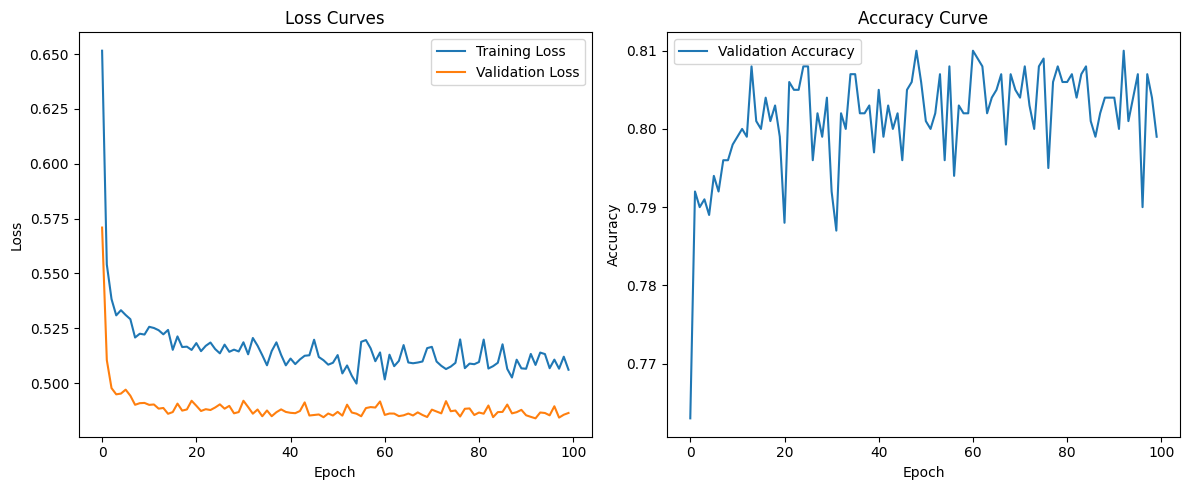


Results for IncomeInvestment

Neural Network Metrics:
           Training   Test
accuracy      0.799  0.799
precision     0.821  0.824
recall        0.610  0.601
f1            0.700  0.695
Prédictions ajoutées : mlp_proba_IncomeInvestment


In [11]:
# Boucle pour chaque cible
for target in targets:
    print(f"\nTraining Enhanced MLP for: {target}")
    print("=" * 60)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)

    # Datasets & Loaders avec InvestmentDatasetFixed
    train_dataset = InvestmentDatasetFixed(X_train, y_train)
    test_dataset = InvestmentDatasetFixed(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Modèle & optimiseur
    model = MLP(input_size=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraînement avec courbes
    model = train_model_with_curves(model, train_loader, test_loader, criterion, optimizer)

    # Prédictions sur l’ensemble du dataset
    dummy_y = pd.Series(np.zeros(len(X)))  # y fictif
    full_dataset = InvestmentDatasetFixed(X, dummy_y)
    full_loader = DataLoader(full_dataset, batch_size=32)

    model.eval()
    all_proba = []

    with torch.no_grad():
        for X_batch, _ in full_loader:
            y_pred = model(X_batch).squeeze()
            all_proba.extend(y_pred.numpy())

    all_proba = np.array(all_proba)
    all_pred = (all_proba > 0.5).astype(int)
    
     # Display final metrics
    print(f"\nResults for {target}")
    print("=" * 50)

    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)

    # Ajout dans df_clients
    df_clients[f'mlp_proba_{target}'] = all_proba

    print(f"Prédictions ajoutées : mlp_proba_{target}")


In [12]:
# Moyenne des proba pour chaque target
df_clients['Final_prediction_IncomeInvestment'] = (
    df_clients[['reg_log_IncomeInvestment_proba', 'xgb_proba_IncomeInvestment', 
                'rf_proba_IncomeInvestment', 'mlp_proba_IncomeInvestment']]
    .mean(axis=1)
    .apply(lambda x: 1 if x >= 0.5 else 0)
)

df_clients.to_excel(
    "df_income_transformed2.xlsx",
    index=False,
    sheet_name="ProcessedData"  # Optional: customize sheet name
)
